In [1]:
import secml
import torch
import foolbox
import matplotlib.pyplot as plt
import tensorflow as tf
from secml.array import CArray

## Downloading data


In [2]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data()
)
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

## Ploting the dataset and the true labels


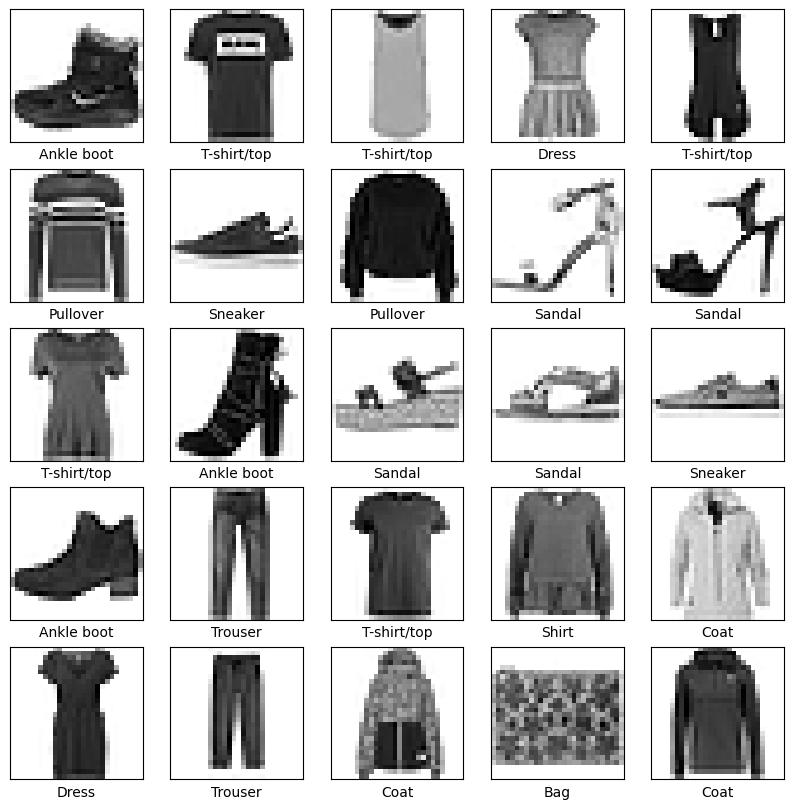

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Normalizing images


In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0
# test_images

## Building model


In [5]:
import torch.nn as nn


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
import torch.optim as optim

net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

## Wrapping model in SecMl


In [7]:
from secml.ml.classifiers import CClassifierPyTorch


clf = CClassifierPyTorch(
    model=net,
    loss=loss_function,
    optimizer=optimizer,
    epochs=10,
    batch_size=20,
    input_shape=(1, 28, 28),
    random_state=0,
)

# Training Model


In [8]:
clf.fit(train_images, train_labels)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [9]:
test = clf.predict(train_images[:67])
train_labels[67].item(), test.argmax()

(0, 0)

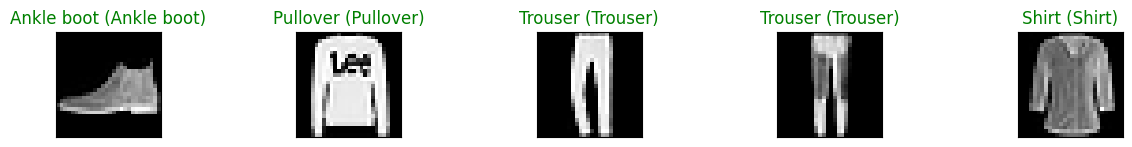

In [32]:
from secml.figure import CFigure


# displaying some examples and their predictions
def show_digits(samples, preds, labels, digs, n_display=8):
    # samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display * 3, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx + 1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap="gray")
        fig.sp.title(
            "{} ({})".format(
                class_names[labels[idx].item()], class_names[preds[idx].item()]
            ),
            color=("green" if labels[idx].item() == preds[idx].item() else "red"),
        )
    fig.show()


digits = list(range(10))
show_digits(
    test_images[:5, :], clf.predict(test_images[:5, :]), test_labels[:5], digits
)

In [11]:
from secml.ml.peval.metrics import CMetricAccuracy
from secml.array import CArray

y_pred = clf.predict(test_images)
metric = CMetricAccuracy()

test_labels = CArray(test_labels)
acc = metric.performance_score(y_true=test_labels, y_pred=y_pred)

print("Accuracy of the original model on Clean Dataset: {:.2%}".format(acc))

Accuracy of the original model on Clean Dataset: 85.72%


## Creating Adversarial examples


In [26]:
x0, y0 = test_images[5:], test_labels[5:]  # initial sample

noise_type = "l2"  # Type of perturbation 'l1' or 'l2'
dmax = 0.4  # Maximum perturbation
lb, ub = 0, 1  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # error-generic

solver_params = {
    "eta": 0.3,
    "eta_min": 0.1,
    "eta_max": None,
    "max_iter": 100,
    "eps": 1e-4,
}

# test_images[5:].shape
# test_labels[5:]

In [29]:
from secml.adv.attacks.evasion import CAttackEvasionPGDLS

pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=clf,
    double_init_ds=train_images,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb,
    ub=ub,
    solver_params=solver_params,
    y_target=y_target,
)

# Run the evasion attack on x0
y_pred_pgdls, _, adv_ds_pgdls, _ = pgd_ls_attack.run(x0, y0)

print("Original x0 label: ", y0)
print("Adversarial example label (PGD-LS): ", y_pred_pgdls)

print(
    "Number of classifier gradient evaluations: {:}" "".format(pgd_ls_attack.grad_eval)
)

Original x0 label:  CArray([1 4 6 ... 8 1 5])
Adversarial example label (PGD-LS):  CArray([1 2 4 ... 8 1 7])
Number of classifier gradient evaluations: 2


Original x0 label:  CArray([1 4 6 ... 8 1 5])
Adversarial example label (PGDLinf):  CArray([9 2 1 ... 8 1 5]) 



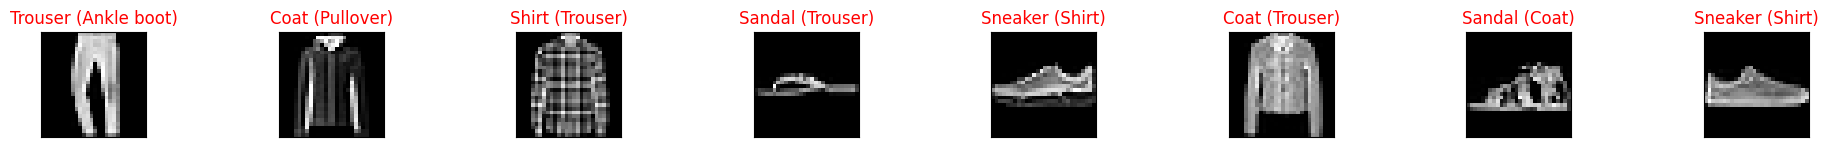

In [43]:
print("Original x0 label: ", y0)
print("Adversarial example label (PGDLinf): ", y_pred, "\n")
digits = list(range(10))
show_digits(x0, y_pred, y0, digits)